# DANCE-MaP analysis of the adenine riboswitch

Here we recreate the visualization from Figure 2C of Olson et al. 2022. [pdf](https://doi.org/10.1016/j.molcel.2022.02.009)

In short, DMS-MaP was performed on an IVT construct of *Vibrio vulnificus* adenine riboswitch in the absence of adenine ligand. DANCE-MaP analysis recapitulates the known states and populations of this riboswitch and provides direct evidence for accepted secondary and tertiary structure interactions. These data are then used to accurately model each state of the ensemble.

DanceMapper post-analysis files are availabe through the GEO (GSE182552). The direct download link is: [GSE182552_RAW.tar](https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE182552&format=file). Extract this folder and the resulting folder, GSM5531266_wt_0_deep_danceoutput.tar.gz to obtain the Dancemapper output files. To predict structures from these data, we run `python ~/DanceMapper/foldClusters.py --bp wt_0_deep wt_0_deep-reactivities.txt wt_0_deep` which produces .ct files. These .ct files were loaded into StructureEditor, part of [RNAstructure](http://rna.urmc.rochester.edu/RNAstructure.html). With this software, structure cassettes were removed and a custom layout for each secondary structure was created to match the original publication (wt_0_deep-0.nsd and wt_0_deep-1.nsd). Finally, the adenine-bound crystal structure was retreived from the RCSB, [here](https://www.rcsb.org/structure/4TZX). These steps yield the 8 files needed for this analysis:

From RCSB:
- 4tzx.pdb

From foldClusters.py followed by StructureEditor:
- wt_0_deep-0.nsd
- wt_0_deep-1.nsd

From original publication:
- wt_0_deep-0-pairmap.txt
- wt_0_deep-1-pairmap.txt
- wt_0_deep-0-rings.txt
- wt_0_deep-rings.txt
- wt_0_deep-reactivities.txt

## Import RNAvigate

The first step in this notebook is to import the RNAvigate python module.

In [1]:
import rnavigate as rnav

## Define experimental samples and provide input file names

DanceMapper output files have a standard naming convention: a sample prefix
followed by a suffix indicating the data type. We provide RNAvigate with the
sample prefix, and it will look for pairmap.txt, rings.txt and reactivities.txt
files.

The .nsd files from Structure Editor contain the structure drawing layout.
These are not part of the standard DanceMapper outputs, so we assign these
manually. We do the same for the 4tzx.pdf ON state crystal structure. We
manually add a "spans" annotation for the Shine-Delgarno sequence. We also
calculate mutual information scores to be used to filter RINGs. See the
Jupyter notebook for figure 4 for a full explaination.

In [2]:
sample = rnav.Sample(
    sample="V.vul adeRS",
    dance_prefix="wt_0_deep")

# replacing automatically generated labels for each DANCE-MaP component
sample.dance[0].sample = "Translation OFF (58%)"
sample.dance[1].sample = "Translation ON (42%)"

# for each component of Dance, we are attaching additional data:
for i, component in enumerate(sample.dance):
    # RINGs mutual information scores
    component.data["ringmap"].data.eval("MI = Statistic / (2 * Mod_Depth)", inplace=True)
    # the .nsd structure drawing file
    component.set_data(name="ct", filepath=f"wt_0_deep-{i}.nsd")
    # the 4tzx.pdb crystal structure
    component.set_data(name="pdb", filepath="4tzx.pdb", chain="X")
    # an annotation corresponding to the Shine-Delgarno sequence
    component.set_data(
        name="SD",
        seq_source="ct",
        instantiator=rnav.data.Annotation,
        spans=[[99, 105]],
        color="DarkOrchid")

Data positions with different sequences
---------------------------------------

Experimental and structural data with different underlying sequences or
reference positions are automatically aligned and repositioned for visual
comparison. These alignments work well when sequences are similar, but it
is a good idea to check this alignment with more divergent sequences.

These alignments can be checked visually using `rnav.plot_alignment()`. Grey
bars indicate positional alignment and red bars indicate mismatches.

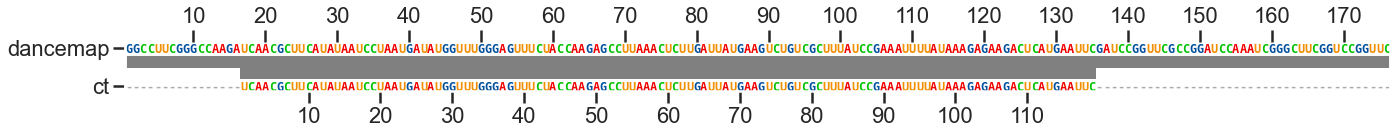

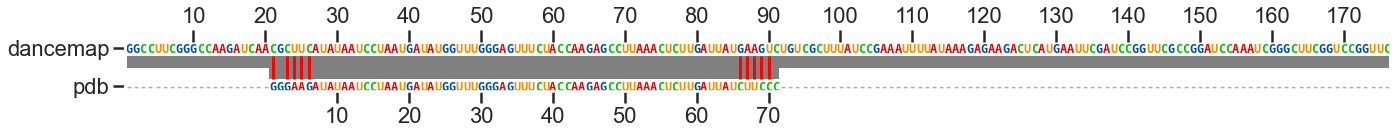

In [3]:
plot = rnav.plot_alignment(
    data1=(sample.dance[0], "dancemap"),
    data2=(sample.dance[0], "ct"),
    labels=["dancemap", "ct"])
plot = rnav.plot_alignment(
    data1=(sample.dance[0], "dancemap"),
    data2=(sample.dance[0], "pdb"),
    labels=["dancemap", "pdb"])

## Display RINGs, PAIRs, and structure model for each component as arc plots

Olson et. al. established filters for visualizing RING-MaP and PAIR-MaP data
that result from DANCE-MaP analysis. These filters are automated below with
`sample.dance_filter(...)`. We will be using a modified version of these filters.

A RING correlation between nucleotides i and j is included if the correlation:
- is positive
- has G<sub>apc</sub> above 23
- has a contact distance between i and j of at least 5
- is between single-stranded nucleotides
- has a mutual information score greater than 0.000025
- has a Zij greater than 2

PAIRs are included only if they agree with the predicted structure.

Then, `rnav.plot_arcs_multisample(...)` is used to create arc plots for each
DANCE component. Arguments are explained in-line below.

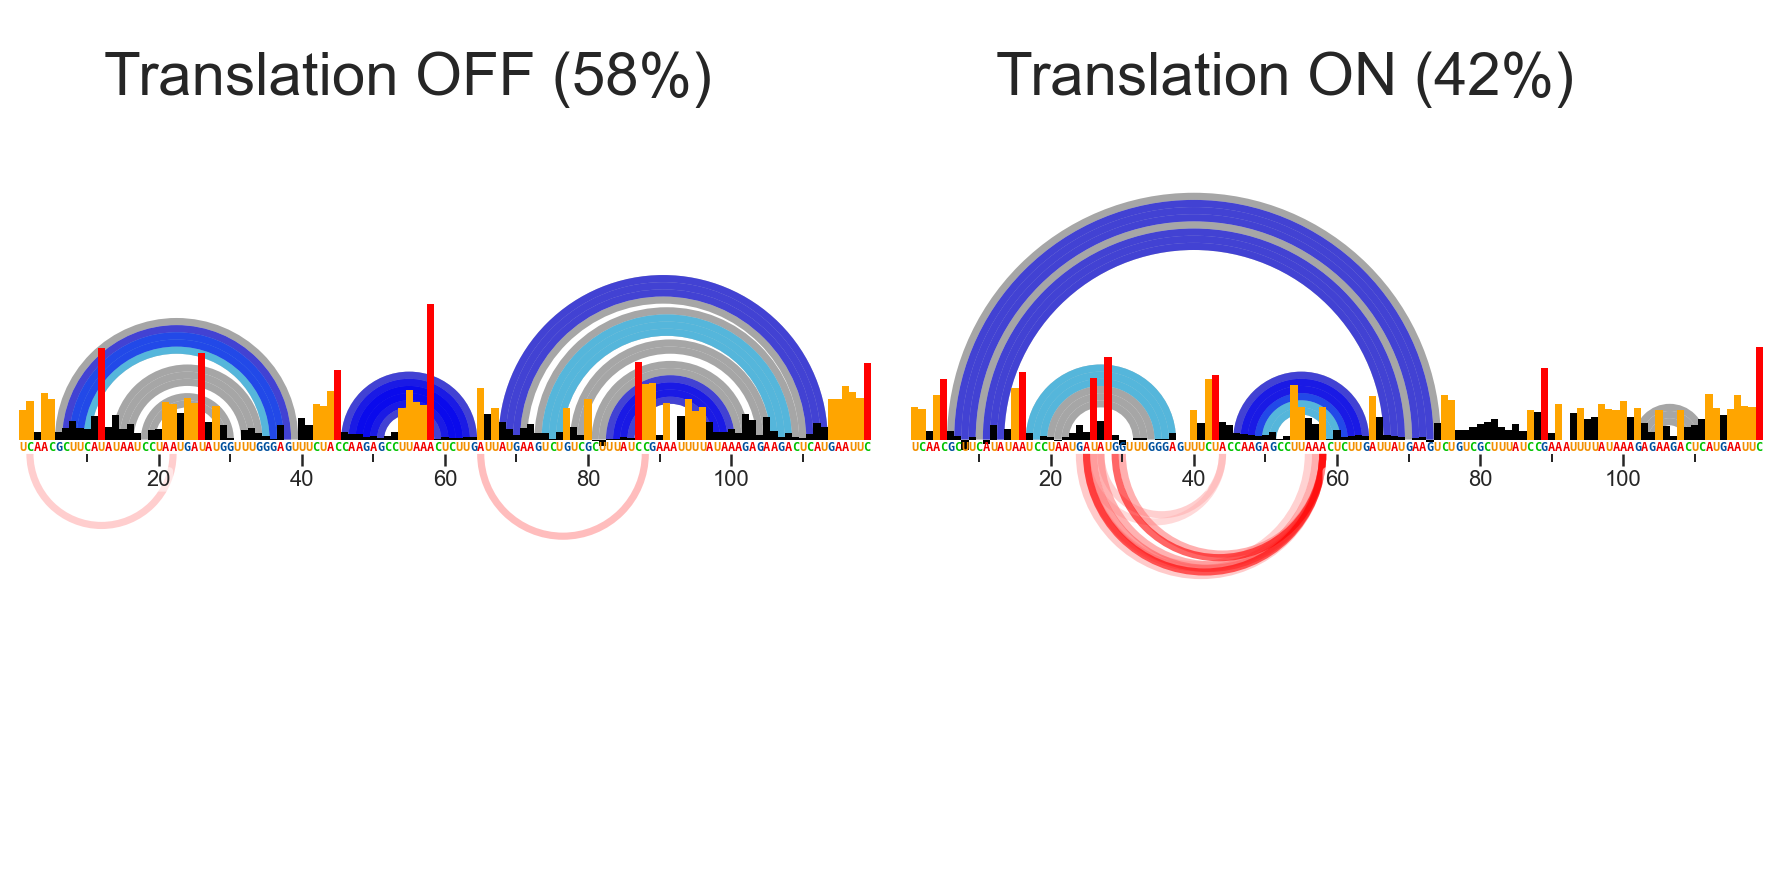

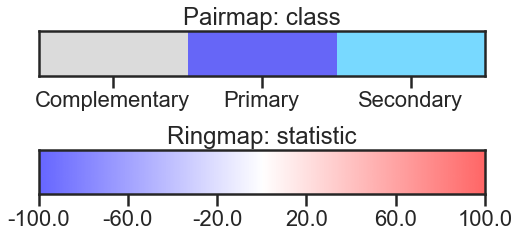

In [4]:
sample.dance_filter(cdfilter=15, MI_ge=0.000025, Zij_ge=2)
plot = rnav.plot_arcs(
    samples=sample.dance,        # Make one plot per dance component
    interactions="pairmap",      # Plot PAIR-MaP data
    interactions_panel="top",    # on the top panel
    interactions_filter={
        "prefiltered": True},    # Preserve the filtering applied above
    interactions2="ringmap",     # Plot RING-MaP data (on bottom by default)
    interactions2_filter={
        "prefiltered":True},     # Preserve the filtering applied above
    plot_error=False)            # Don't plot error bars on profile
# plot.save("ade_arcs.svg")

## Display filtered RINGs on secondary structure drawings for each component

Text(3, -1, 'SD')

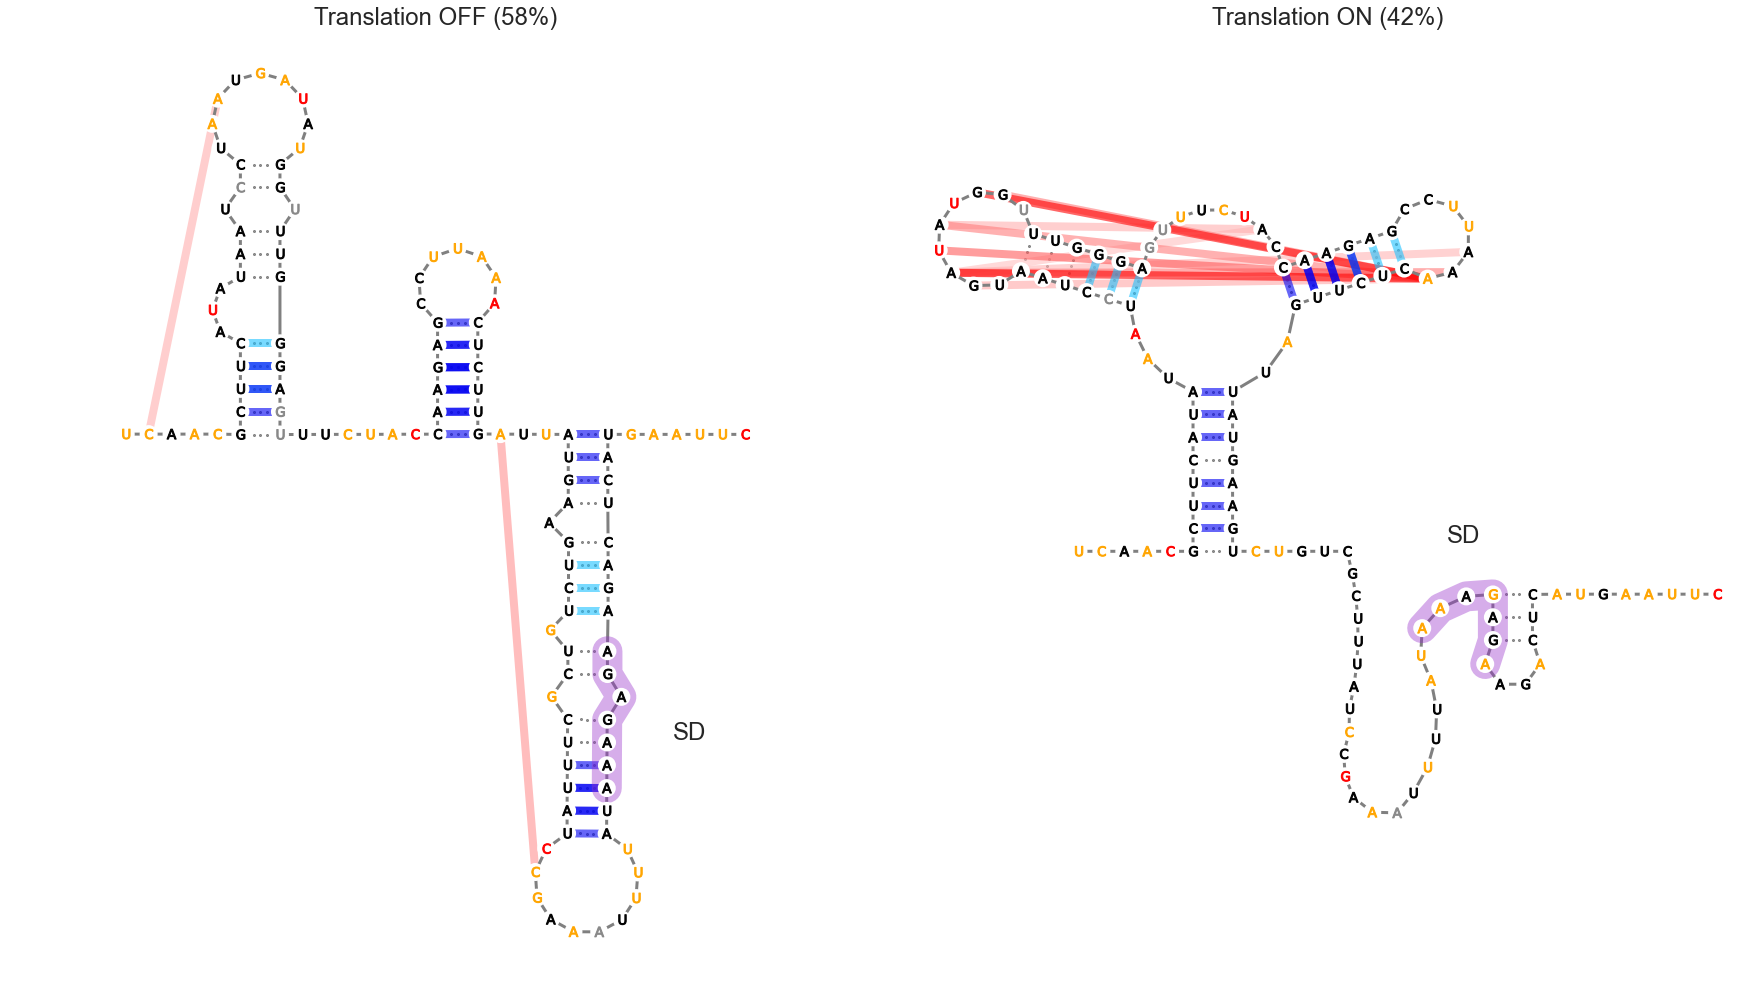

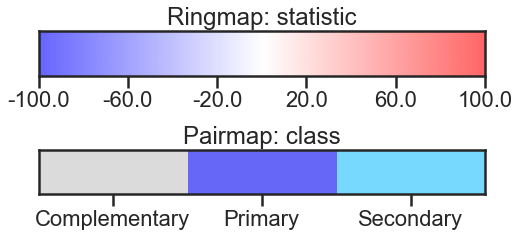

In [5]:
plot = rnav.plot_ss(
    samples=sample.dance,      # plot structure diagram for each dance component
    ss="ct",                   # Use the structure drawing coordinates from the ct data
    annotations=["SD"],        # highlight the shine-dalgarno sequence
    interactions2="pairmap",   # plot PAIR-MaP data
    interactions2_filter={
        "prefiltered": True},  # maintain the dance filter applied earlier
    interactions="ringmap",    # plot RING-MaP data
    interactions_filter={
        "prefiltered": True},  # maintain the dance filter applied earlier
    colors="profile",          # use shapemap reactivity colors
    apply_color_to="sequence", # applied to the sequence letters
    plot_kwargs={
        "data_lw":8,           # make the interactions lines thicker
        "data_z": 0,           # put interaction lines "behind" other plot elements
    })
plot.get_ax(0).text(6, -6, 'SD')
plot.get_ax(1).text(3, -1, 'SD')
# plot.save("ade_ss.svg")

## Display filtered RINGs on 3D structure

RINGs are filtered according to secondary structure. This requires a positional
alignment as described above. These filtered RINGs are then repositioned again
to be displayed on the 3D structure below. This multiple repositioning of data
is a significant time-saving feature of RNAvigate.

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

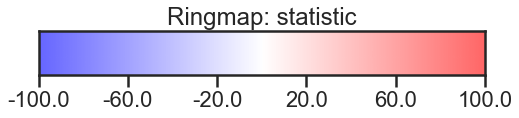

In [6]:
sample.dance_filter(fit_to='pdb', cdfilter=15, MI_ge=0.000025, Zij_ge=2)
plot = sample.dance[1].plot_mol(    # make a 3D rendering of the ON state
    interactions="ringmap",         # plot RING-MaP interactions
    interactions_filter={
        "prefiltered": True},       # preserve the filtering applied above
    atom="DMS",                     # Draw RING cylinders between DMS-reactive atoms (N1 for A and C, N3 for U and G)
    nt_color="grey",                # Color RNA grey
    plot_kwargs={
        "width": 800,
        "height": 800,              # change plot dimensions
        "background_alpha": 0,      # make background transparent
        "orientation": [21.49, -19.50, 11.15, -70.90, -0.50, -0.84, -0.04, 0.22]
                                    # use this predetermined orientation
    },
    title=False,                    # don't display the title
)

In [7]:
# plot.save()